In [3]:
import os
import glob
folder_path = "/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/layer_hidden_states2"
dataset_paths = glob.glob(os.path.join(folder_path, "*.csv"))
dataset_paths = [path for path in dataset_paths if "multi_token" in path]
dataset_paths.sort()

model_colors = {
    "Babel-9B-Chat": "#66c2a5",
    "gemma-3-12b-it": "#fc8d62",
    "Llama-2-7b-chat-hf": "#e78ac3"
}

# Define colors for each language
language_colors = {
    "English": "#1f77b4",
    "Korean": "#ff7f0e",
    "German": "#2ca02c"
}

# Define line styles for each model
model_styles = {
    "Babel-9B-Chat": "-",
    "gemma-3-12b-it": "--",
    "Llama-2-7b-chat-hf": ":"
}

language_styles = {
    "English": "-",
    "Korean": "--",
    "German": ":"
}

version_colors = {
    "": "#1f77b4",  # Blue
    "v2": "#ff7f0e",  # Orange
    "v3": "#165a16",  # Green
    "v4": "#d62728"   # Red
}

version_linestyles = {
    "": ":",
    "v2": "--",
    "v3": "-.",
    "v4": ":"
}


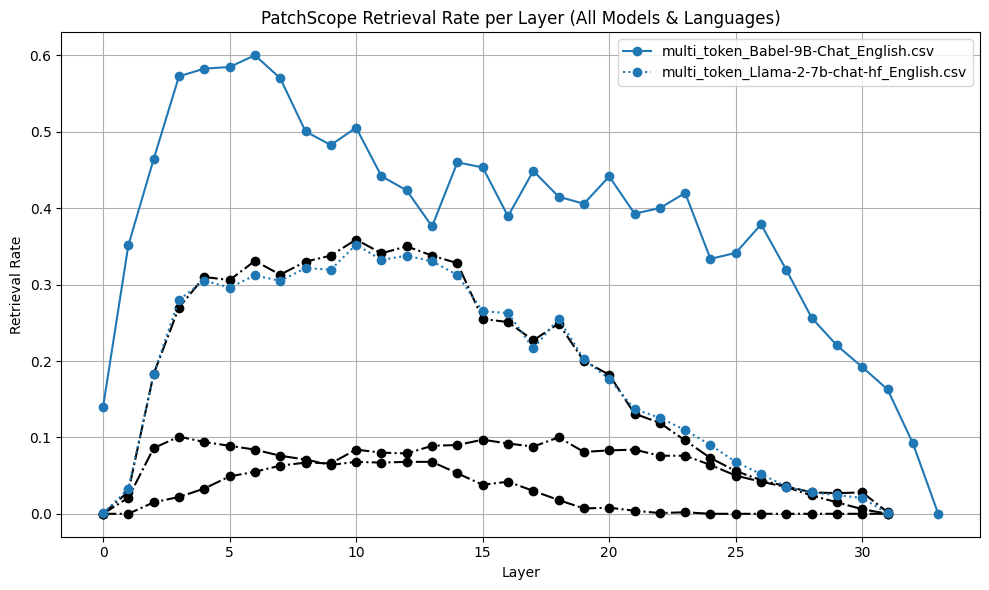

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))


for path in dataset_paths:
    # Extract model and language from the file name
    filename = os.path.basename(path)
    model_short = filename.split("_")[2]
    lang = filename.split("_")[3].split(".")[0]
    version = filename.split("_")[-1].split(".")[0]

    # Load CSV
    df = pd.read_csv(path)
    df['retrieved'] = df.apply(lambda row: str(row['word']) in str(row['patchscope_result']), axis=1)
    retrieval_rate = df.groupby('layer')['retrieved'].mean()

    # Plot
    plt.plot(
        retrieval_rate.index,
        retrieval_rate.values,
        marker='o',
        # label=f"{model_short}-{lang}",
        label = filename,
        color=language_colors.get(lang, "black"),  # Use the color for the language
        # color=version_colors.get(version, "black"),  # Use the color for the version
        # color = model_colors.get(model_short, "black"),  # Use the color for the model
        # color=model_styles.get(model_short, "black"),  # Use the color for the language
        linestyle=model_styles.get(model_short, "dashdot"),  # Use the line style for the model
        # linestyle=version_linestyles.get(version, "-")  # Use the line style for the version
    )

plt.xlabel("Layer")
plt.ylabel("Retrieval Rate")
plt.title("PatchScope Retrieval Rate per Layer (All Models & Languages)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

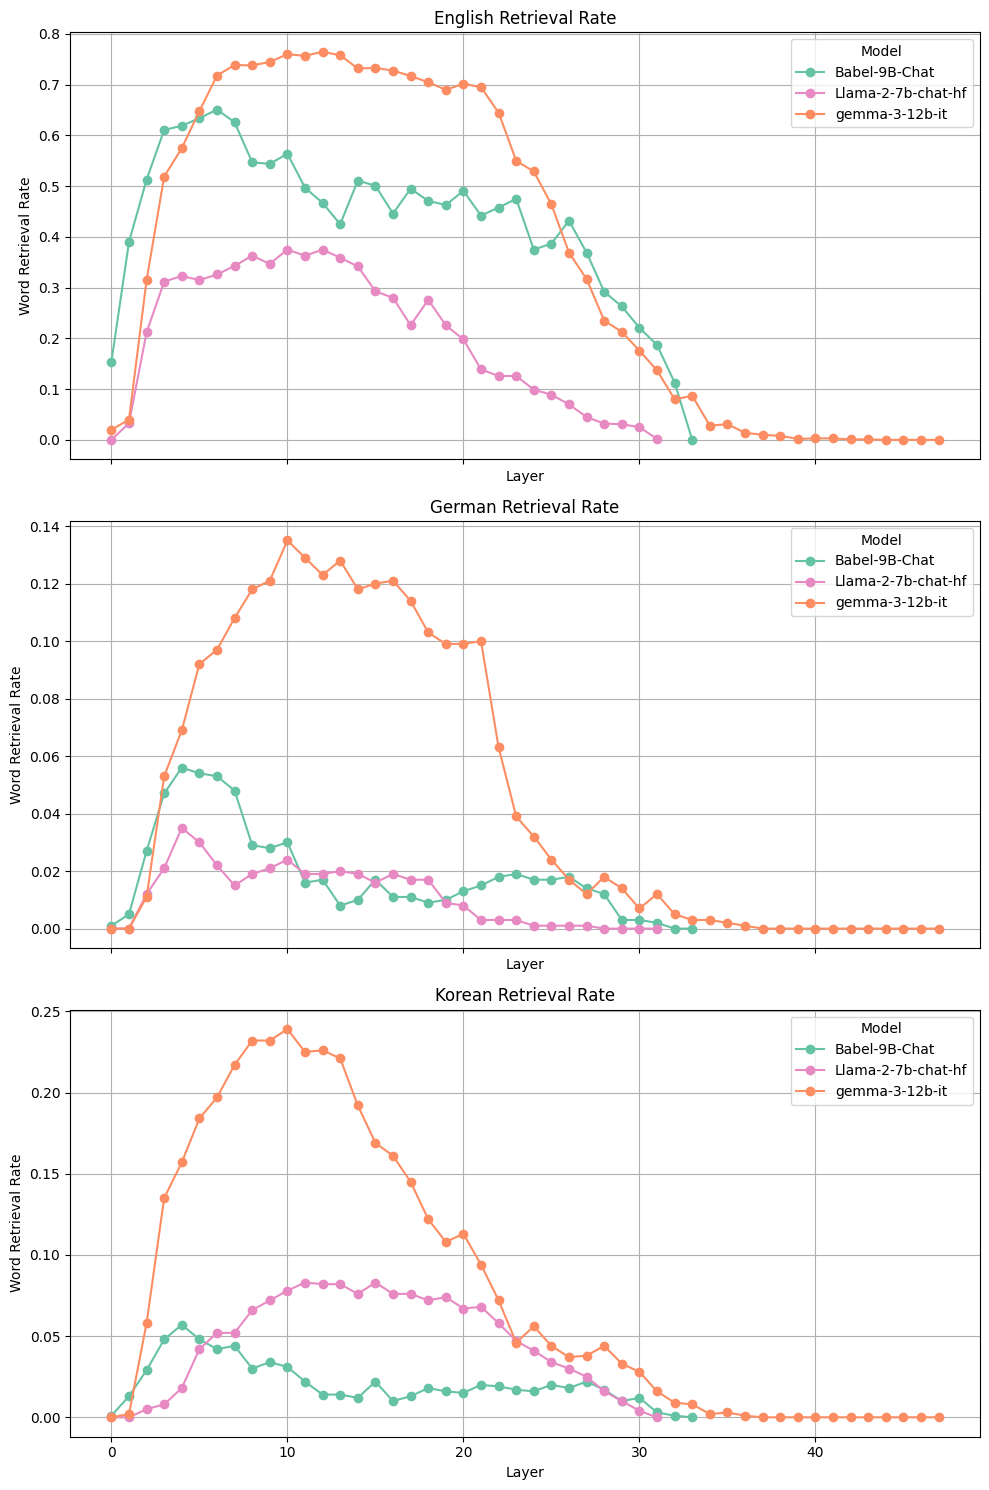

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Group dataset paths by language
language_datasets = {"English": [], "German": [], "Korean": []}
for path in dataset_paths:
    filename = os.path.basename(path)
    lang = filename.split("_")[3].split(".")[0]
    language_datasets[lang].append(path)

# Create subplots for each language
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

for ax, (lang, paths) in zip(axes, language_datasets.items()):
    for path in paths:
        filename = os.path.basename(path)
        model_short = filename.split("_")[2]

        # Load CSV
        df = pd.read_csv(path)
        df['retrieved'] = df.apply(lambda row: str(row['word']) in str(row['patchscope_result']), axis=1)
        retrieval_rate = df.groupby('layer')['retrieved'].mean()

        # Plot
        ax.plot(
            retrieval_rate.index,
            retrieval_rate.values,
            marker='o',
            label=model_short,
            color=model_colors.get(model_short, "black"),
        )

    ax.set_title(f"{lang} Retrieval Rate")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Word Retrieval Rate")
    ax.legend(title="Model")
    ax.grid(True)

plt.tight_layout()
plt.show()

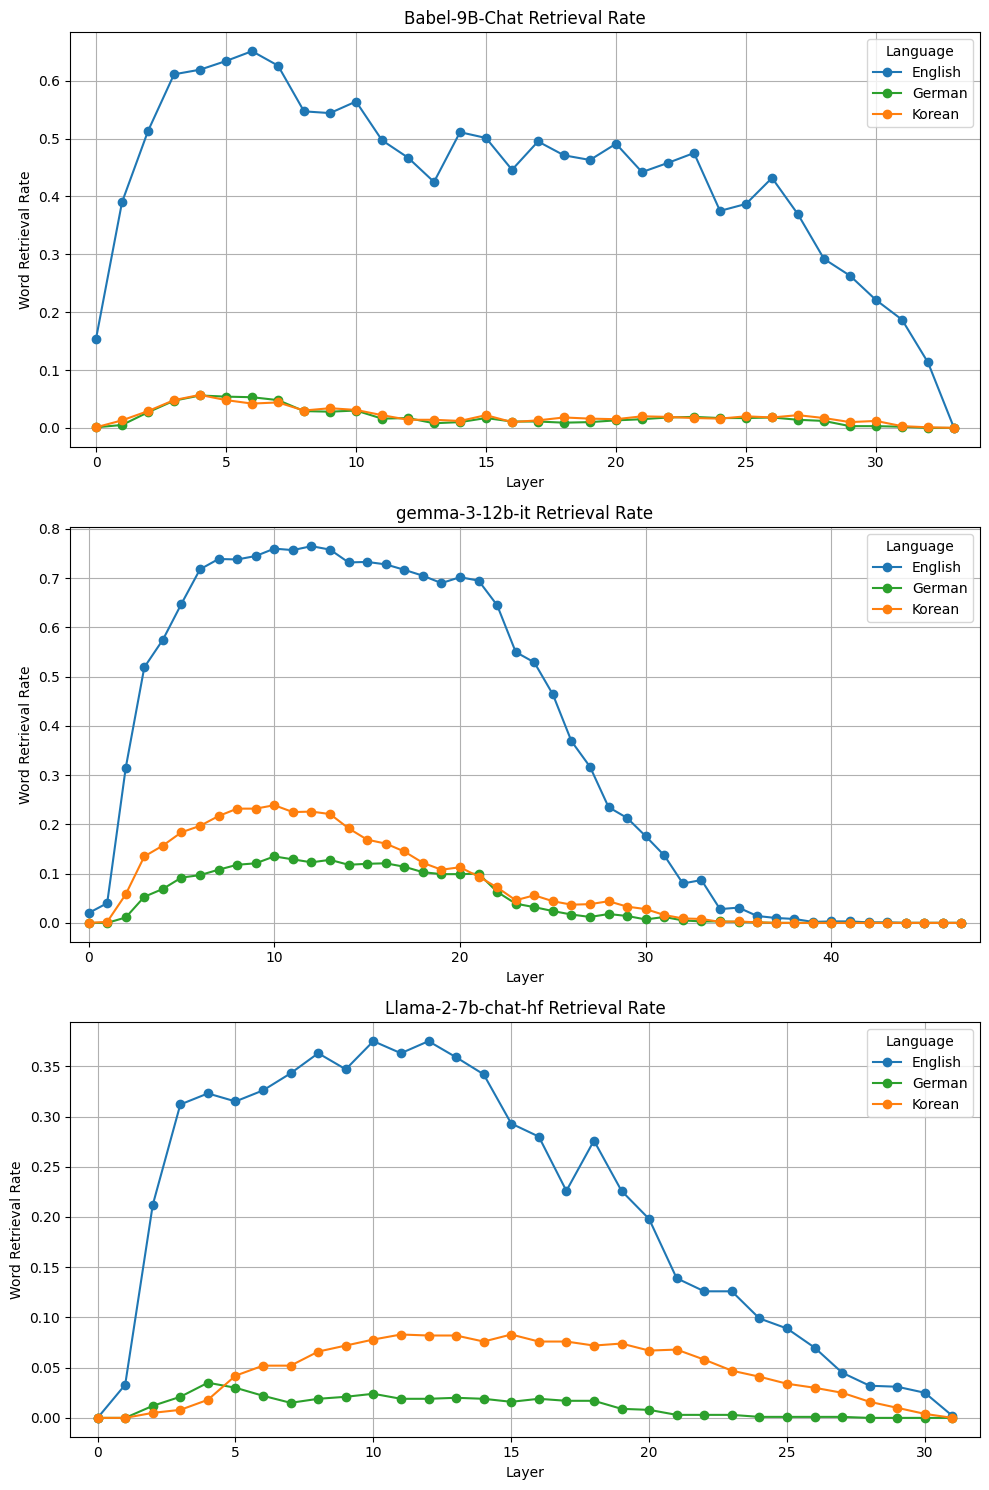

In [4]:
# Group dataset paths by model
model_datasets = {}
for path in dataset_paths:
    filename = os.path.basename(path)
    model_short = filename.split("_")[2]
    if model_short not in model_datasets:
        model_datasets[model_short] = []
    model_datasets[model_short].append(path)

desired_order = ["Babel-9B-Chat", "gemma-3-12b-it", "Llama-2-7b-chat-hf"]

# Sort the model_datasets dictionary based on the desired order
model_datasets = {model: model_datasets[model] for model in desired_order if model in model_datasets}

# Create subplots for each model
fig, axes = plt.subplots(len(model_datasets), 1, figsize=(10, 5 * len(model_datasets)), sharex=False)

for ax, (model, paths) in zip(axes, model_datasets.items()):
    all_layers = []  # To track all layers for setting x-axis limits
    for path in paths:
        filename = os.path.basename(path)
        lang = filename.split("_")[3].split(".")[0]

        # Load CSV
        df = pd.read_csv(path)
        df['retrieved'] = df.apply(lambda row: str(row['word']) in str(row['patchscope_result']), axis=1)
        retrieval_rate = df.groupby('layer')['retrieved'].mean()

        # Track layers for x-axis limits
        all_layers.extend(retrieval_rate.index)

        # Plot
        ax.plot(
            retrieval_rate.index,
            retrieval_rate.values,
            marker='o',
            label=lang,
            color=language_colors.get(lang, "black")
        )

    # Set x-axis limits dynamically based on layers
    ax.set_xlim([min(all_layers)-1, max(all_layers)+1])

    ax.set_title(f"{model} Retrieval Rate")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Word Retrieval Rate")
    ax.legend(title="Language")
    ax.grid(True)

plt.tight_layout()
plt.show()

# Further Analysis

In [20]:
import pandas as pd
from ast import literal_eval
from scipy.stats import entropy

THRESHOLD = 10
TOP_K = 5

# Function to calculate repetition and degeneracy metrics
def calculate_repetition_degeneracy(df):
    repetition = df['word'].duplicated().mean()  # Fraction of repeated words
    degeneracy = df['patchscope_result'].apply(lambda x: len(set(str(x).split()))).mean()  # Average unique tokens in results
    return repetition, degeneracy

# Create a table for each dataset
results = []
layer_results = []  # For layer-wise analysis
for path in dataset_paths:
    filename = os.path.basename(path)
    model_short = filename.split("_")[2]
    lang = filename.split("_")[3].split(".")[0]

    # Load CSV
    df = pd.read_csv(path)

    # Calculate repetition and degeneracy metrics
    repetition, degeneracy = calculate_repetition_degeneracy(df)

    # Calculate additional metrics
    value_counts = df['patchscope_result'].value_counts()
    total = len(df)
    unique = value_counts.count()
    duplicate_ratio = 1 - unique / total
    count_over_threshold = (value_counts > THRESHOLD).sum()
    top_k_total = value_counts.head(TOP_K).sum()
    top_k_ratio = top_k_total / total
    probabilities = value_counts / value_counts.sum()
    ent = entropy(probabilities, base=2)

    # Append overall results
    results.append({
        'Model': model_short,
        'Language': lang,
        'Repetition': repetition,
        'Degeneracy': degeneracy,
        'Total Outputs': total,
        'Unique Outputs': unique,
        'Duplicate Ratio': f"{duplicate_ratio:.2%}",
        f"# Outputs >{THRESHOLD}": count_over_threshold,
        f"Top {TOP_K} %": f"{top_k_ratio:.2%}",
        'Entropy (bits)': round(ent, 2)
    })

    # Layer-wise analysis
    for layer, layer_df in df.groupby('layer'):
        layer_value_counts = layer_df['patchscope_result'].value_counts()
        layer_total = len(layer_df)
        layer_unique = layer_value_counts.count()
        layer_duplicate_ratio = 1 - layer_unique / layer_total
        layer_count_over_threshold = (layer_value_counts > THRESHOLD).sum()
        layer_top_k_total = layer_value_counts.head(TOP_K).sum()
        layer_top_k_ratio = layer_top_k_total / layer_total
        layer_probabilities = layer_value_counts / layer_value_counts.sum()
        layer_ent = entropy(layer_probabilities, base=2)
        most_frequent_output = layer_value_counts.idxmax()  # Get the most frequent output
        top_3_outputs = layer_value_counts.head(3).to_dict()  # Get the top 3 most frequent outputs as a dictionary

        layer_results.append({
            'Model': model_short,
            'Language': lang,
            'Layer': layer+1,
            'Total Outputs': layer_total,
            'Unique Outputs': layer_unique,
            'Duplicate Ratio': f"{layer_duplicate_ratio:.2%}",
            f"# Outputs >{THRESHOLD}": layer_count_over_threshold,
            f"Top {TOP_K} %": f"{layer_top_k_ratio:.2%}",
            'Entropy (bits)': round(layer_ent, 2),
            'Most Frequent Output': most_frequent_output,
            'Top 3 Outputs': top_3_outputs
        })

# Convert results to DataFrames and display
results_df = pd.DataFrame(results)
layer_results_df = pd.DataFrame(layer_results)
print("Overall Results:")
print(results_df)
print("\nLayer-wise Results:")
print(layer_results_df)

# Optionally save the tables to CSV files
results_df.to_csv("repetition_degeneracy_table.csv", index=False)
layer_results_df.to_csv("layer_wise_analysis_table.csv", index=False)

Layer 1 - Top 3 Most Frequent Outputs:
patchscope_result
2) 2) 2)     162
1) 1) 1)      17
2) 3) 3)      12
Name: count, dtype: int64
Layer 2 - Top 3 Most Frequent Outputs:
patchscope_result
2) 2) 2)     190
1) 1) 1)      37
1) 2) 1)      34
Name: count, dtype: int64
Layer 3 - Top 3 Most Frequent Outputs:
patchscope_result
2) 2) 2)     126
1) 1) 1)      31
2) 3) 3)      31
Name: count, dtype: int64
Layer 4 - Top 3 Most Frequent Outputs:
patchscope_result
2) 2) 2)     91
1) 2) 1)     44
2) 3) 3)     40
Name: count, dtype: int64
Layer 5 - Top 3 Most Frequent Outputs:
patchscope_result
2) 2) 2)     79
2) 3) 3)     55
1) 2) 1)     51
Name: count, dtype: int64
Layer 6 - Top 3 Most Frequent Outputs:
patchscope_result
2) 2) 2)     86
1) 2) 1)     60
2) 3) 3)     48
Name: count, dtype: int64
Layer 7 - Top 3 Most Frequent Outputs:
patchscope_result
1) 2) 1)     84
2) 2) 2)     51
2) 3) 3)     51
Name: count, dtype: int64
Layer 8 - Top 3 Most Frequent Outputs:
patchscope_result
1) 2) 1)     113


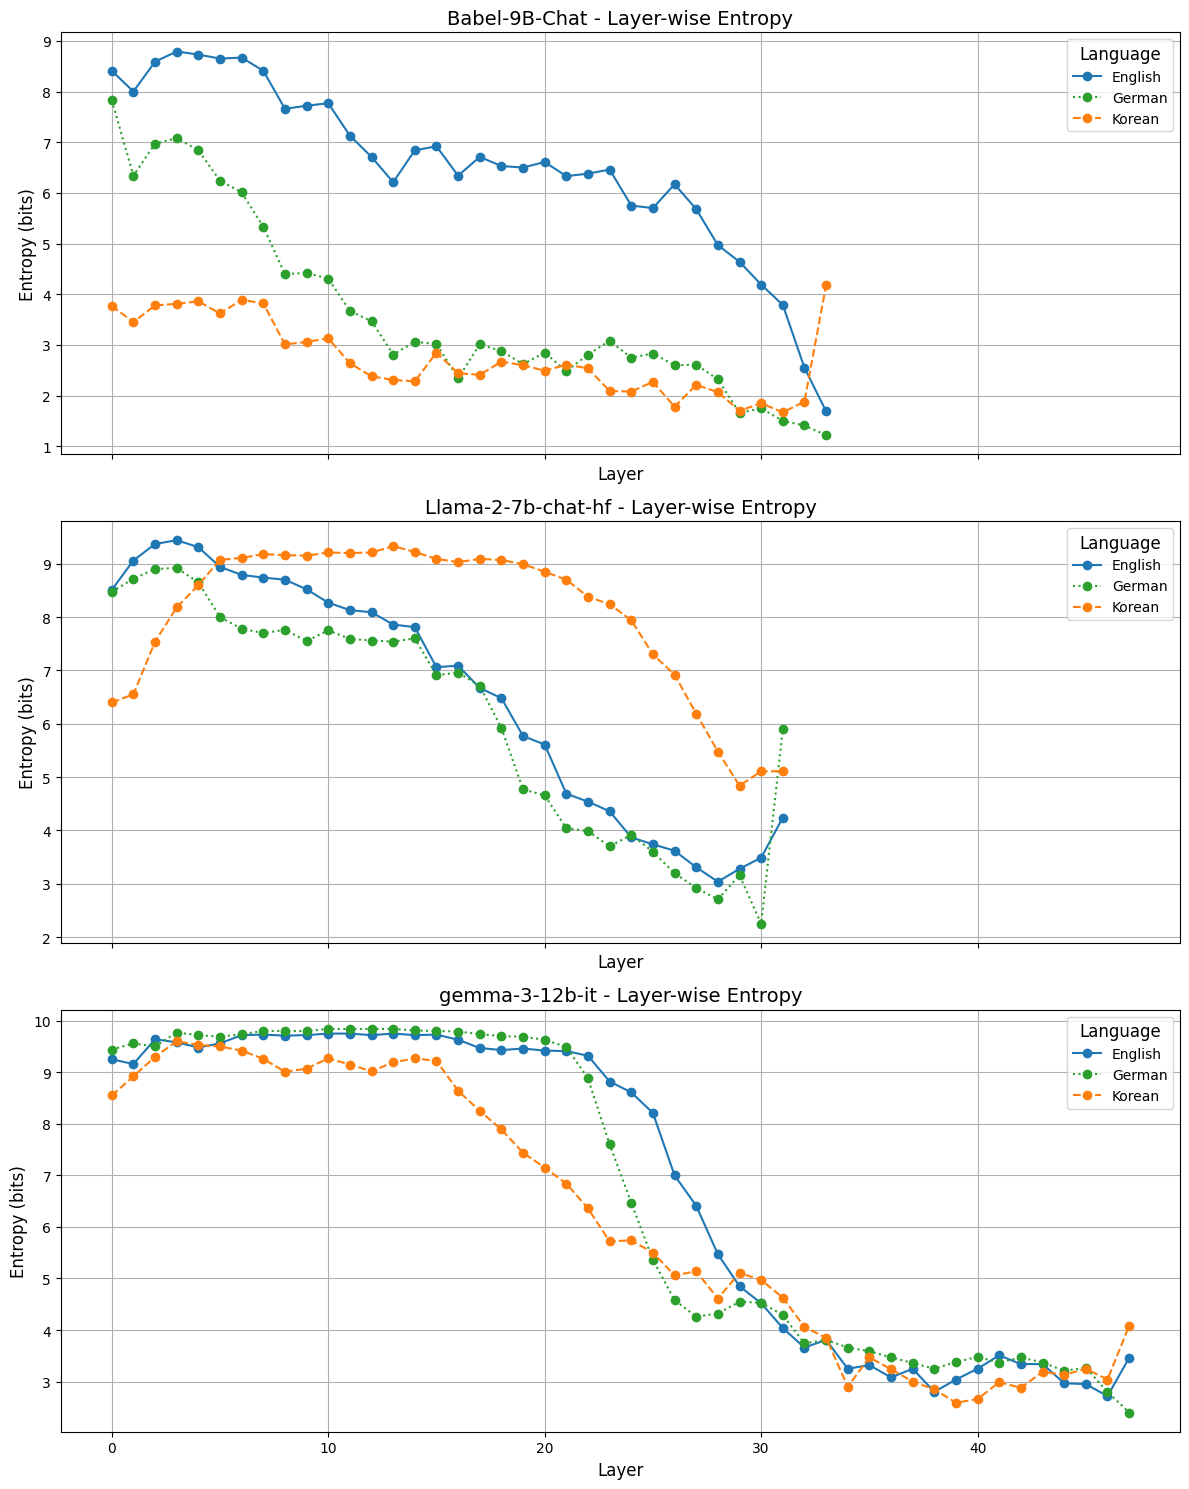

In [15]:
import matplotlib.pyplot as plt

# Prepare data for visualization
layerwise_entropy_data = layer_results_df[['Model', 'Language', 'Layer', 'Entropy (bits)']]

# Get unique models for subplots
unique_models = layerwise_entropy_data['Model'].unique()
num_models = len(unique_models)

# Create subplots for each model
fig, axes = plt.subplots(num_models, 1, figsize=(12, 5 * num_models), sharex=True)

for ax, model in zip(axes, unique_models):
    model_data = layerwise_entropy_data[layerwise_entropy_data['Model'] == model]
    for language, group in model_data.groupby('Language'):
        ax.plot(
            group['Layer'],
            group['Entropy (bits)'],
            marker='o',
            label=f"{language}",
            color=language_colors.get(language, "black"),
            linestyle=languague_styles.get(language, "-")
        )
    ax.set_title(f"{model} - Layer-wise Entropy", fontsize=14)
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("Entropy (bits)", fontsize=12)
    ax.legend(title="Language", fontsize=10, title_fontsize=12)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [32]:
import plotly.express as px
import pandas as pd
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Function to generate heatmaps with 3 subplots per model (one for each language)
def generate_model_language_heatmaps(dataset_paths):
    # Group dataset paths by model
    model_datasets = {}
    for path in dataset_paths:
        filename = os.path.basename(path)
        model_short = filename.split("_")[2]
        if model_short not in model_datasets:
            model_datasets[model_short] = []
        model_datasets[model_short].append(path)

    # Iterate over each model
    for model, paths in model_datasets.items():
        # Create a subplot with 3 rows (one for each language)
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=["English", "German", "Korean"],
            shared_xaxes=True,
            vertical_spacing=0.07  # Reduce space between subplots
        )

        # Group paths by language
        language_datasets = {"English": [], "German": [], "Korean": []}
        for path in paths:
            filename = os.path.basename(path)
            lang = filename.split("_")[3].split(".")[0]
            if lang in language_datasets:
                language_datasets[lang].append(path)

        # Generate heatmaps for each language
        for i, (lang, lang_paths) in enumerate(language_datasets.items(), start=1):
            # Combine data for the language
            combined_data = pd.DataFrame()
            for path in lang_paths:
                df = pd.read_csv(path)
                combined_data = pd.concat([combined_data, df])

            # Get the top 5 most frequent outputs globally
            global_top5 = combined_data['patchscope_result'].value_counts().head(5).index

            # Create a dictionary to store counts for each layer
            top5_by_layer = {}
            for layer, layer_df in combined_data.groupby('layer'):
                filtered = layer_df[layer_df['patchscope_result'].isin(global_top5)]
                counts = filtered['patchscope_result'].value_counts()
                top5_by_layer[layer] = counts

            # Convert the dictionary to a DataFrame and fill missing values with 0
            heatmap_data = pd.DataFrame(top5_by_layer).fillna(0)

            # Add heatmap to the subplot
            fig.add_trace(
                go.Heatmap(
                    z=heatmap_data.values,
                    x=heatmap_data.columns,  # Layers
                    y=heatmap_data.index,    # Tokens
                    colorscale="YlOrBr",
                    # colorbar=dict(title="Frequency"),
                    coloraxis="coloraxis",
                    text=heatmap_data.values,  # Optional: Remove this line if not needed
                    texttemplate="%{z}"  # Display only the frequency value
                ),
                row=i, col=1
            )

        # Update layout
        fig.update_layout(
            title=f"Top 5 Most Frequent Output by Layer for {model}",
            xaxis_title=None,
            yaxis_title=None,
            height=500,  # Adjust height for 3 subplots
            width=1200,
            coloraxis=dict(
                colorscale="YlOrBr",                 # <--- put colorscale here
                colorbar=dict(title="Frequency")     # <--- single shared colorbar
            )
        )
        fig.update_xaxes(title_text="Layer", row=3, col=1)
        fig.update_yaxes(title_text="Generated Output", row=2, col=1)

        # Show the figure
        fig.show()

# Call the function
generate_model_language_heatmaps(dataset_paths)

In [5]:
import json
import os
import sys
from typing import Dict, Any, Optional, Tuple, Union, List
from transformers import AutoTokenizer, AutoModelForCausalLM, Gemma3ForConditionalGeneration, Qwen2ForCausalLM
import pandas as pd
import torch
from tqdm import tqdm

# Base directory for the project
BASE_DIR = "/home/hyujang/multilingual-inner-lexicon"

def load_config(config_path: str = None) -> Dict[str, Any]:
    """Load main configuration file."""
    if config_path is None:
        config_path = os.path.join(BASE_DIR, "RQ1/config.json")
    
    with open(config_path, "r") as f:
        return json.load(f)

def load_user_config(user_config_path: str = None) -> Dict[str, Any]:
    """Load user configuration file with tokens."""
    if user_config_path is None:
        user_config_path = os.path.join(BASE_DIR, "user_config.json")
    
    try:
        with open(user_config_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print("Warning: user_config.json not found")
        return {"huggingface_token": {}}

def get_token_value(tokenizer_name: str, config: Dict[str, Any] = None, user_config: Dict[str, Any] = None) -> Optional[str]:
    """Get token value for a specific tokenizer."""
    if config is None:
        config = load_config()
    if user_config is None:
        user_config = load_user_config()
    
    token_key = config.get("tokenizers", {}).get(tokenizer_name)
    if token_key:
        return user_config.get("huggingface_token", {}).get(token_key)
    return None

def setup_tokenizer(tokenizer_name: str, use_fast: bool = True) -> AutoTokenizer:
    """Setup tokenizer with proper token handling and special configurations."""
    token_value = get_token_value(tokenizer_name)
    
    tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_name, 
        use_fast=use_fast, 
        token=token_value
    )
    
    return tokenizer

model_full_name_map = {
    "Llama-2-7b-chat-hf": "meta-llama/Llama-2-7b-chat-hf",
    "Babel-9B-Chat": "Tower-Babel/Babel-9B-Chat",
    "gemma-3-12b-it": "google/gemma-3-12b-it"
}


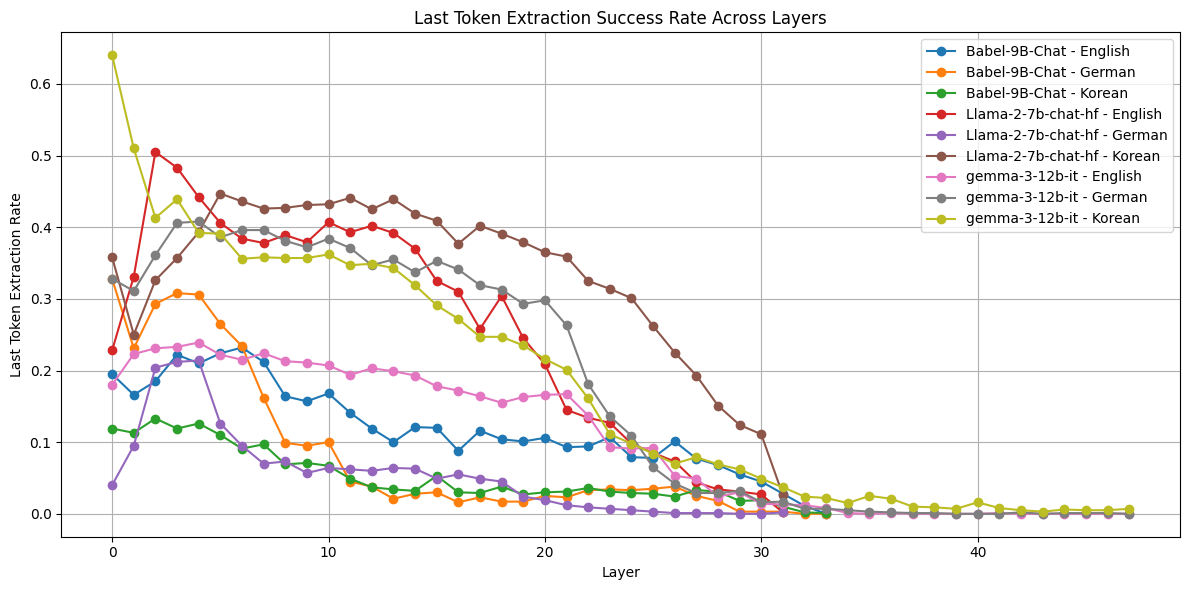

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
# from utils import setup_tokenizer  # Changed to absolute import to fix ImportError

# Function to check if the last token of the target word was successfully extracted
def check_last_token_extraction(row, tokenizer):
    # Tokenize the target word
    target_tokens = tokenizer.tokenize(row['word'])
    if not target_tokens:
        return False  # If no tokens are generated, return False
    
    target_last_token = target_tokens[-1]  # Get the last token of the target word
    output_tokens = tokenizer.tokenize(row['patchscope_result'])  # Tokenize the output
    return target_last_token in output_tokens  # Check if the last token is in the output

# Analyze last token extraction for each dataset
last_token_results = []
for path in dataset_paths:
    filename = os.path.basename(path)
    model_short = filename.split("_")[2]
    lang = filename.split("_")[3].split(".")[0]

    # Setup tokenizer
    tokenizer = setup_tokenizer(model_full_name_map[model_short])

    # Load CSV
    df = pd.read_csv(path)
    
    # Add a column to check last token extraction
    df['last_token_extracted'] = df.apply(check_last_token_extraction, axis=1, tokenizer=tokenizer)

    # Calculate the success rate of last token extraction per layer
    last_token_rate = df.groupby('layer')['last_token_extracted'].mean()

    # Store results for visualization
    last_token_results.append({
        'Model': model_short,
        'Language': lang,
        'Layer': last_token_rate.index.tolist(),
        'Last Token Extraction Rate': last_token_rate.values.tolist()
    })

# Visualize the results
plt.figure(figsize=(12, 6))
for result in last_token_results:
    layers = result['Layer']
    rates = result['Last Token Extraction Rate']
    label = f"{result['Model']} - {result['Language']}"
    plt.plot(layers, rates, marker='o', label=label)

plt.xlabel("Layer")
plt.ylabel("Last Token Extraction Rate")
plt.title("Last Token Extraction Success Rate Across Layers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

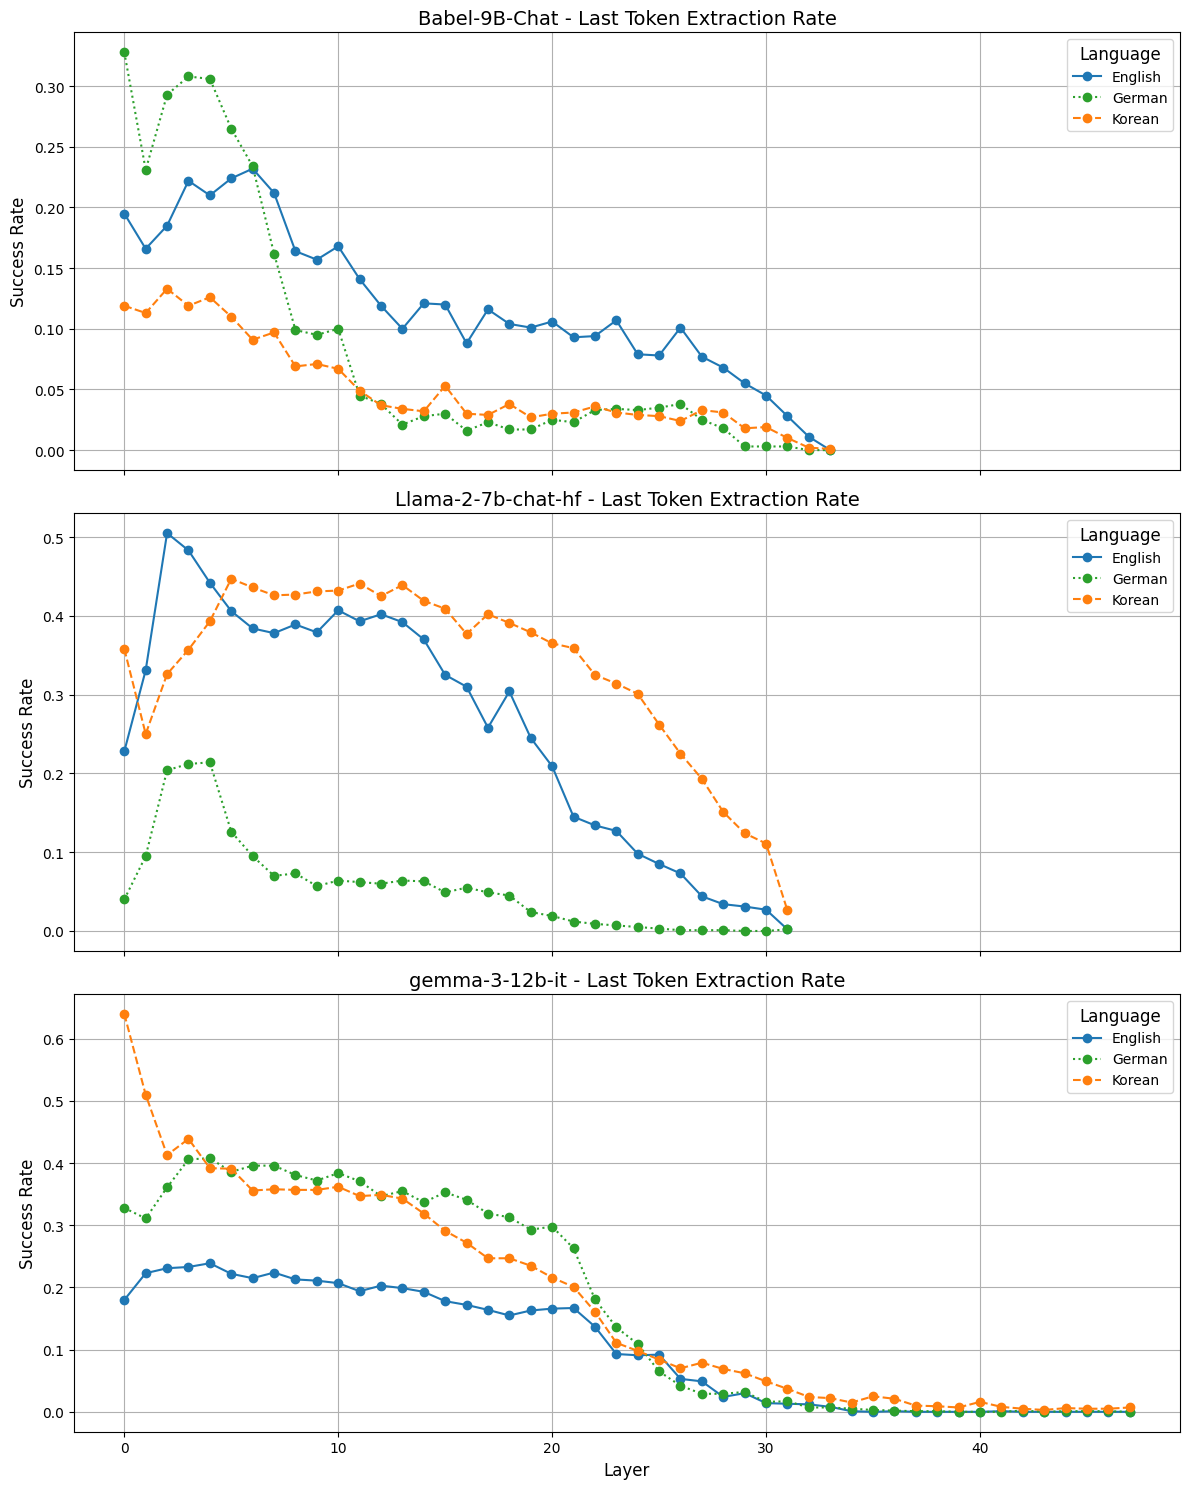

In [7]:
# Prepare a combined DataFrame for easier plotting
all_results = []
for path in dataset_paths:
    filename = os.path.basename(path)
    model_short = filename.split("_")[2]
    lang = filename.split("_")[3].split(".")[0]

    # Setup tokenizer
    tokenizer = setup_tokenizer(model_full_name_map[model_short])

    # Load CSV
    df = pd.read_csv(path)

    # Add a column to check last token extraction
    df['last_token_extracted'] = df.apply(check_last_token_extraction, axis=1, tokenizer=tokenizer)

    # Calculate success rate per layer
    last_token_rate = df.groupby('layer')['last_token_extracted'].mean().reset_index()
    last_token_rate['Model'] = model_short
    last_token_rate['Language'] = lang

    all_results.append(last_token_rate)

# Combine all into a single DataFrame
combined_df = pd.concat(all_results, ignore_index=True)

# Get unique models for subplots
unique_models = combined_df['Model'].unique()
num_models = len(unique_models)

# Create subplots
fig, axes = plt.subplots(num_models, 1, figsize=(12, 5 * num_models), sharex=True)

if num_models == 1:
    axes = [axes]  # Ensure axes is iterable for single subplot

for ax, model in zip(axes, unique_models):
    model_data = combined_df[combined_df['Model'] == model]
    for language, group in model_data.groupby('Language'):
        ax.plot(
            group['layer'],
            group['last_token_extracted'],
            marker='o',
            label=language,
            color=language_colors.get(language, "black"),
            linestyle=language_styles.get(language, "-")
        )
    ax.set_title(f"{model} - Last Token Extraction Rate", fontsize=14)
    ax.set_ylabel("Success Rate", fontsize=12)
    ax.legend(title="Language", fontsize=10, title_fontsize=12)
    ax.grid(True)

axes[-1].set_xlabel("Layer", fontsize=12)  # Only bottom subplot has x-label

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Function to check if a word is retrieved correctly in at least one layer
def check_word_retrieval(df):
    # Group by word and check if retrieved is True in any layer
    df['retrieved'] = df.apply(lambda row: str(row['word']) in str(row['patchscope_result']), axis=1)
    df['retrieved_in_any_layer'] = df.groupby('word')['retrieved'].transform('max')
    return df

# Analyze retrieval for each dataset
retrieval_results = []
for path in dataset_paths:
    filename = os.path.basename(path)
    model_short = filename.split("_")[2]
    lang = filename.split("_")[3].split(".")[0]

    # Load CSV
    df = pd.read_csv(path)

    # Check if the word is retrieved in any layer
    df = check_word_retrieval(df)

    # Calculate the proportion of words retrieved in at least one layer
    retrieval_rate = df['retrieved_in_any_layer'].mean()

    # Store results
    retrieval_results.append({
        'Model': model_short,
        'Language': lang,
        'Retrieval Rate (Any Layer)': retrieval_rate
    })

# Convert results to a DataFrame and display
retrieval_results_df = pd.DataFrame(retrieval_results)
print(retrieval_results_df)

                Model Language  Retrieval Rate (Any Layer)
0       Babel-9B-Chat  English                       0.715
1       Babel-9B-Chat   German                       0.091
2       Babel-9B-Chat   Korean                       0.106
3  Llama-2-7b-chat-hf  English                       0.610
4  Llama-2-7b-chat-hf   German                       0.065
5  Llama-2-7b-chat-hf   Korean                       0.141
6      gemma-3-12b-it  English                       0.849
7      gemma-3-12b-it   German                       0.225
8      gemma-3-12b-it   Korean                       0.367
